## 文本的表征

---

### 介绍

受过教育的人类可以轻易地看懂一段文字，但是对于机器而言，这些符号就是天书了。那么，机器如何读懂一段文本？其实道理也很简单，将文本转化为机器所熟知的数值形式便可以了。对于图像而言，像素值便是天然的数值形式。而对于语言而言，需要通过更复杂的转换及表征。本实验主要介绍文本的表征以及，在进一步的文本分析中，文本相似度的计算。

#### 知识点

- 基于频次的文本表征
- 基于 TF-IDF 的文本表征
- 基于词向量的文本表征
- 如何计算文本相似度

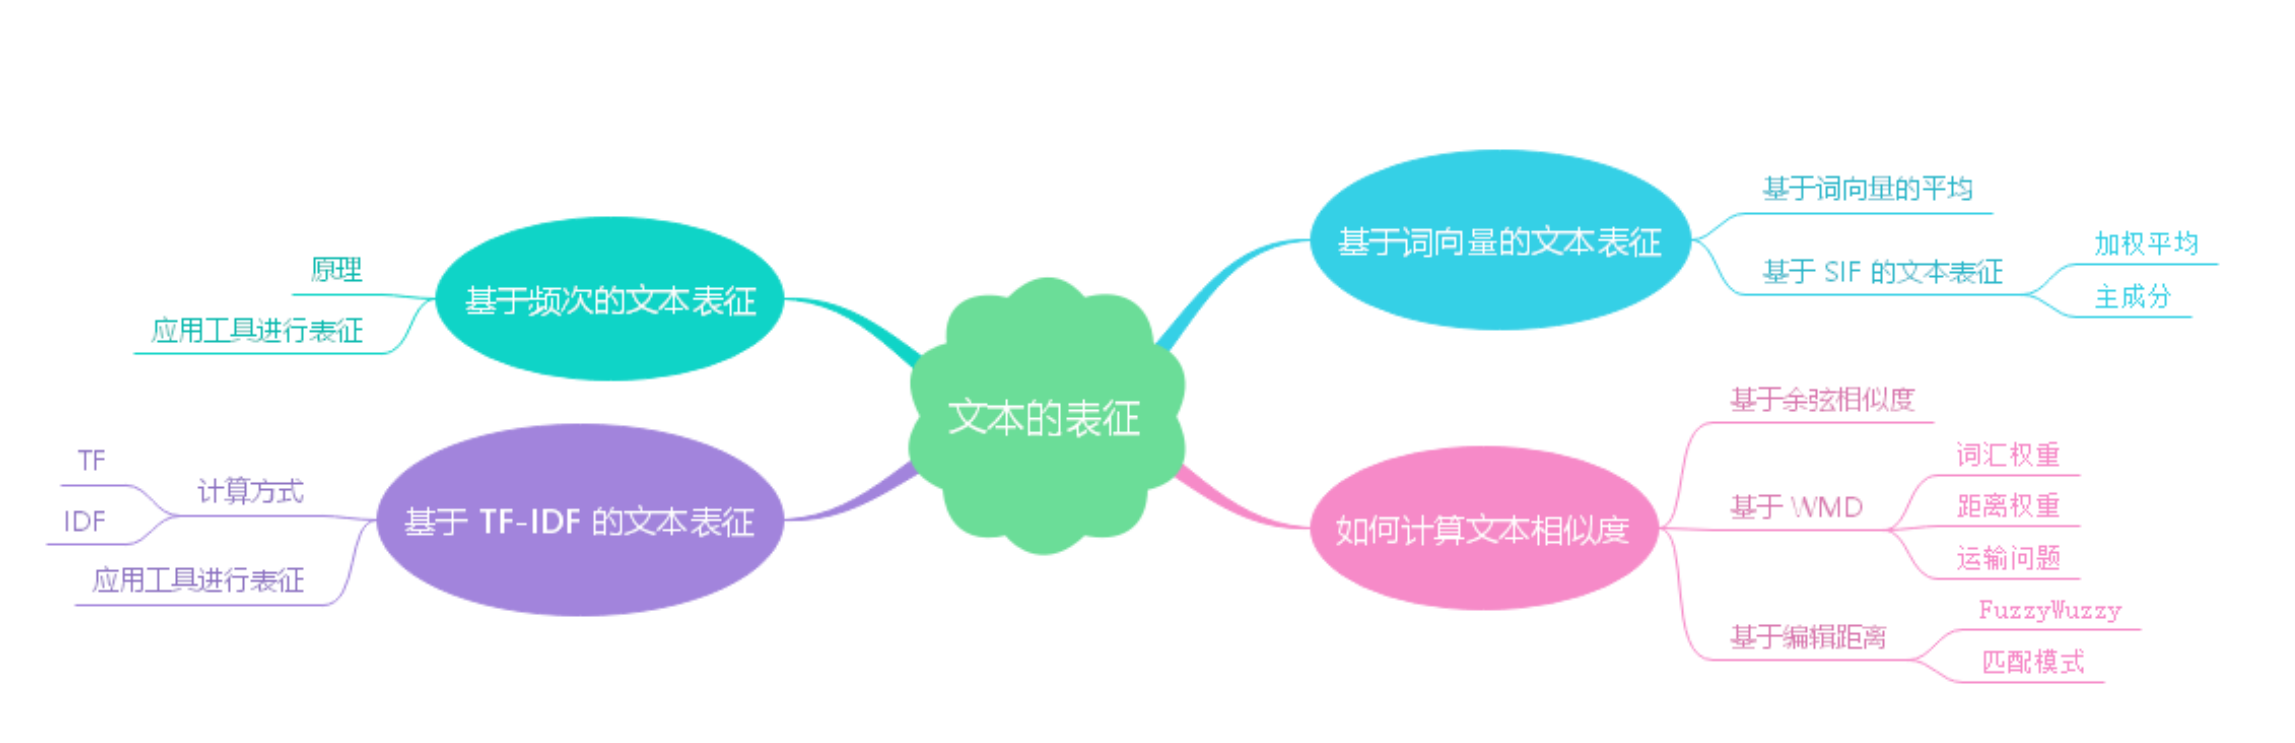

### 基于频次的文本表征

基于频次的文本表征，专业术语称为词袋模型（Bag-of-Words, BOW），顾名思义，即把文本中的词用袋子装起来统一作为文本的表示。基于词频的词袋模型是将文本进行数值化表示的一种简单模型。具体地，文本的表示与词典的大小、词的索引以及词在文本中的出现频次相关，下面以一个简单的例子表述其构建过程。

假设数据集（现代诗人卞之琳于 1935 年创作的一首现代诗歌《断章》）为两个经过预处理且分好词的句子：

- 你/站在/桥上/看/风景/看/风景/的/人/在/楼上/看/你
- 明月/装饰/了/你/的/窗子/你/装饰/了/别人/的/梦

可得对应的长度为 15 的词典为：[“你”，“站在”，“桥上”，“看”，“风景”，“的”，“人”，“在”，“楼上”，“明月”，“装饰”，“了”，“窗子”，“别人”，“梦”]

每个句子的数值化表达（或者说向量化表示）的长度均为词典长度，并且计算词典中各个词在句子中的出现频次，按照词的索引位置进行填充，以上两个句子的向量化表示如下：

- [2, 1, 1, 3, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]
- [2, 0, 0, 0, 0, 2, 0, 0, 0, 1, 2, 2, 1, 1, 1]

以第一个向量为例，首位对应词典中的词为“你”，在第一个句子中出现了 2 次，第二个位置对应词典中的词为“站在”，出现了 1 次，而最后 6 个位置分别对应单词“明月”、“装饰”、“了”、“窗子”、“别人”、“梦”，在第一个句子中并无出现，因此对应的数值为 0。

基于频次的词袋模型的特点如下：

- 优点：简单易用，原理明晰；
- 缺点：没有考虑词序、词之间的联系以及文法，丢失了许多重要信息，另外，实际情况中词典的大小成千或上万，因此文本表示是一个非常稀疏的高维向量（大部分位置为 0 ）。

利用 Python 工具包 Gensim 以及 scikit-learn 都可以轻松地将文本转化为基于词频的词袋表示，并且可以配置某些参数，接下来还是以诗作《断章》为例进行代码演示。这里我们来看如何利用 Gensim 进行文本的词袋表征。

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 教学代码：</i>

In [ ]:
import jieba
# 数据
raw_texts = [
    '你站在桥上看风景',
    '看风景的人在楼上看你',
    '明月装饰了你的窗子',
    '你装饰了别人的梦',
]
texts = [jieba.lcut(text, cut_all=True) for text in raw_texts]  # 分词

<i class="fa fa-arrow-circle-down" aria-hidden="true"> 动手练习:</i>

In [ ]:
from gensim.corpora import Dictionary
dictionary = Dictionary(texts)  # 建立词典
print(dictionary.token2id)

对文本进行词袋表示：

In [ ]:
bow_texts = [dictionary.doc2bow(text) for text in texts]
bow_texts

需要注意的是，这里基于词频的文本词袋表示与上面理论中的向量表示形式不同，这是由于这两种表示方式都会产生稀疏矩阵，为了节省存储空间，只将其中的非零元素取出并用 tuple 的形式表示。

数组中的每一个子数组表示文本中的一句话，包含多个 tuple，其前一项表示单词在词典中的索引，后一项表示在相应句子中出现的频次，如第一个子数组中的第一个 tuple（0，1）表示“你”在第一个句子中出现了 1 次。

### 基于 TF-IDF 的文本表征

TF-IDF（term frequency-inverse document frequency）的核心包含两部分，TF 表示某个词在某一文本中出现的频率，IDF 为逆向文档频率，与某词在综合语料库中出现的频率相关。TF-IDF 可用于评估某一词对所在文本的重要程度，其在当前文本中出现频次越多，而在其它文本中出现频次越少，我们可认为此词越是重要。

例如单词“原子弹”在某一文本中出现次数很多，而在总体语料库中并不常见，因此对此当前文本来说，“原子弹”属于十分关键的词汇，又比如“的”在此篇文本中也时常出现，但其在总体语料中也十分常见，因此它并不是特别重要的词汇。用 TF-IDF 表示单词兼顾了局部与整体，相比单纯地考虑词频更加合理一些。假设我们的语料库为若干篇文本，接下来看具体的公式表达：

$$TF_{i,j} = \frac{n_{i,j}}{\sum_k{n_{k,j}}}$$

$TF_{i,j}$ 表示第 j 篇文本中第 i 个词的 TF 值，$n_{i,j}$ 表示第 j 篇文本中第 i 个词的出现频次，$\sum_k{n_{k,j}}$ 则表示第 j 篇文本中所有词的出现频次，k 表示第 j 篇文本中的词汇量。

$$IDF_{i,j} = log\frac{|D|}{1+|D_{t_i}|}$$

$IDF_{i,j}$ 表示第 j 篇文本中第 i 个词的 IDF 值，$|D|$ 表示数据库中文本的总数，$|D_{t_i}|$ 则表示数据库中含词 $t_i$ 的文本数量，为了防止该词语在语料库中不存在使得分母为 0 的情况，取 $1+|D_{t_i}|$ 作为分母，$\frac{|D|}{1+|D_{t_i}|}$ 取对数是为了防止概率过小而不方便计算。

接下来计算第 j 篇文本中第 i 个词的 TF-IDF 值：

$$TF\_IDF_{i,j} = TF_{i,j}*IDF_{i,j}$$

现在来看一个具体的例子，假设某一文本中“原子弹”的出现次数为 3，而其总词汇量为 100，那么“原子弹”在此文本中的TF值为 3/100=0.03。另外，假设“原子弹”在 10000000 份文本构成的数据库中的 999 份文本中出现过，其逆向文档频率则为 log(10000000/1000) = 4。综合两者，最后的 TF-IDF 值为 0.03*4=0.12。某一文档的 TF-IDF 表示即所有单词对应的 TF-IDF 所组合而成的向量。

虽然，相比于基于频次的词袋模型，TF-IDF 考虑地更加全面，然而此方法还是没有考虑到语序以及更深层次的语义，并且其每个文本的 TF-IDF 表示向量也需要同词典大小的维度，因而也是稀疏向量的形式。

接下来应用 Gensim 进行文本的 TF-IDF 表示。

In [ ]:
# 文本的 TF-IDF 表示，在以上词袋结果 bow_texts 上作进一步处理即可
from gensim.models import TfidfModel
tfidf = TfidfModel(bow_texts)
tfidf_texts = [tfidf[text] for text in bow_texts]
tfidf_texts

同样，数组中的每一个子数组表示文本中的一句话，其中每个 tuple 的前一项表示单词索引，后一项表示 TF-IDF 值。可以观察到第一个子数组中没有了索引为 0（即单词“你”）的相关 tuple 项，这是因为 Gensim 具备去除停用词的默认功能。

### 基于词向量的文本表征

在以上内容中我们学习了基于频次统计的文本表示方式，没有考虑到语序以及更深层次的语义，在实际应用中已并不多见。而基于词向量的文本表征是应用更为广泛的有效表征方式，这里介绍两种方法：

- 基于词向量的平均
- 基于 SIF 的文本表征

第一种方法很简单很直观，利用已训练好的词向量模型，直接取文本中所有单词的词向量，相加平均即得到文本对应的向量表征，维度同词向量一致。

In [ ]:
import jieba
import numpy as np


# 基于词向量平均的文本表征
def represent_text_by_average_w2v(w2v_model, text):
    # w2v_model 为词向量模型, text 为输入的文本
    text_cuted = jieba.lcut(text)  # 分词
    text_w2v = []
    for word in text_cuted:  # 遍历文本中的所有单词
        try:
            text_w2v.append(w2v_model[word])  # 获取词向量
        except:
            pass
    text_w2v = np.mean(np.array(text_w2v), axis=0)  # 词向量相加并平均
    return text_w2v

加载上一实验中训练好的词向量模型，获取词向量，进而表征文本。

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/hongloumeng_model.bin"
from gensim.models import KeyedVectors
hongloumeng_w2v_model = KeyedVectors.load_word2vec_format(
    "hongloumeng_model.bin", binary=True)  # 加载词向量模型
text = "黛玉在林中赏月"
average_w2v_text = represent_text_by_average_w2v(
    hongloumeng_w2v_model, text)  # 文本表征

In [ ]:
average_w2v_text  # 表示为维度为 100 的向量

基于词向量的简单平均没有体现不同单词在文本中的重要性，并且一些重要的信息也会被平均掉，因此并非最优选择。接下来介绍第二种方法，基于 SIF 的文本表征，来源于 ICLR 会议论文 "A SIMPLE BUT TOUGH-TO-BEAT BASELINE FOR SENTENCE EMBEDDINGS"， 在实验中表明效果较好，流程如下：

- 对一系列句子中的单词向量进行加权平均，得到句向量。其中频率高的单词，其权重也更小（论文作者认为高频词不那么重要），权重计算方式为 $\frac{a}{a+p(w)}$，基中 a 为超参数，论文中建议 a 的范围为 [1e−4,1e−3]，p(w) 为单词频率。
- 对这些句向量组成的矩阵计算第一主成分，每个句子原有的向量减去其在第一主成分上的矢量投影得到最终的句向量。之所以这样的操作的原因在于，论文作者认为“在第一主成分上的矢量投影”代表了这些句子的共性，相减之后得到的句向量更能凸显独有的特征。

基于以上逻辑，可知我们首先需要具备所有单词的词频信息。

In [ ]:
from collections import Counter
import jieba
import re


# 获取单词频次
def compute_word_freq(file_path):
    texts = ""
    with open(file_path, "r", encoding="utf-8") as f:
        for text in f.readlines():
            text = re.sub("[^\u4e00-\u9fa5]", "", text.strip())  # 只保留中文
            texts += text
    texts_cuted = jieba.lcut(texts)  # 分词
    word_freq = Counter(texts_cuted)
    word_num = len(texts_cuted)
    return word_freq, word_num

由于需要计算第一主成分，即文本的共性，所以在操作中是输入多个文本得到基于词频权重的多个文本向量组成的矩阵。

In [ ]:
# 对文本进行词向量的平均
def represent_texts_by_average_w2v(w2v_model, texts, word_freq, word_num, a):
    # w2v_model 指词向量模型 , texts 指输入的文本, word_freq 指词频词典, word_num 指语料中词汇总量, a 为计算权重公式中的超参数
    texts_vec = []  # 文本向量
    for text in texts:  # 遍历所有文本
        text_cuted = jieba.lcut(text)
        text_w2v = []  # 存储某个文本中所有词向量
        for word in text_cuted:
            try:
                text_w2v.append(
                    w2v_model[word]*a/(a + word_freq[word]/word_num))  # 加权后的词向量存储
            except:
                pass
        text_vec = np.mean(np.array(text_w2v), axis=0)  # 加权平均
        texts_vec.append(text_vec)
    return np.array(texts_vec)

去除第一主成分：

In [ ]:
from sklearn.decomposition import TruncatedSVD


def remove_pc(X):
    # X 表示输入的文本向量组成的矩阵
    svd = TruncatedSVD(n_components=1, n_iter=7, random_state=0)
    svd.fit(X)
    pc = svd.components_  # 获取第一主成分
    return X - X.dot(pc.transpose()) * pc  # 减去第一主成分上的投影并返回

综合以上函数，进行基于 SIF 的文本表征。

In [ ]:
def SIF_embedding(w2v_model, texts, word_freq, word_num, a=0.001):
    texts_w2v = represent_texts_by_average_w2v(
        w2v_model, texts, word_freq, word_num, a)
    return remove_pc(texts_w2v)

In [ ]:
对多个文本进行表征：

In [ ]:
!wget -nc "https://labfile.oss.aliyuncs.com/courses/3205/hongloumeng.txt"
# 所有文本
texts = ["黛玉在林中赏月", "宝玉在林间闲逛", "宝钗喜欢去二爷家串门"]
word_freq, word_num = compute_word_freq(
    "hongloumeng.txt")  # 以红楼梦作为语料计算词频
hongloumeng_w2v_model = KeyedVectors.load_word2vec_format(
    "hongloumeng_model.bin", binary=True)  # 加载词向量模型
texts_vec = SIF_embedding(hongloumeng_w2v_model, texts, word_freq, word_num)

In [ ]:
texts_vec[0]  # 可按照下标取对应文本的表征

### 如何计算文本相似度

在以上内容中我们学习了如何表征文本，基于词频或是基于词向量，而事实上，文本表征的目的在于可进行后续更多的文本分析、语义挖掘等任务。其中最常见的一大应用是文本相似度的计算，这是很多项目的基础工作，比如搜索引擎（需要计算搜索键入内容与推荐文本的相似度）、基于检索的问答系统等。在这里学习三种文本相似度比较方式：

- 基于余弦相似度
- 基于 WMD （Word Mover's Distance， 词移距离）
- 基于编辑距离

余弦相似度，是通过计算两个向量的夹角余弦值来评估它们的相似度。余弦值的范围在 [-1,1] 之间，值越趋近于 1，代表两个向量的方向越接近；越趋近于 -1，他们的方向越相反；接近于 0，表示两个向量近乎于正交。在将文本表示为向量的条件下，可以很容易地利用余弦相似度来代表两个文本的相似度。

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


# 文本相似度比较
def compute_texts_similarity(text1, text2, w2v_model):
    average_w2v_text1 = represent_text_by_average_w2v(
        w2v_model, text1)  # 基于词向量平均获取 text1 的向量
    average_w2v_text2 = represent_text_by_average_w2v(
        w2v_model, text2)  # 基于词向量平均获取 text2 的向量
    similarity = cosine_similarity(
        np.array([average_w2v_text1]), np.array([average_w2v_text2]))  # 计算余弦相似度
    return similarity[0][0]

In [ ]:
text1 = "黛玉在林中赏月"
text2 = "宝玉在林间闲逛"
text3 = "宝钗喜欢去二爷家串门"
# 从结果可知 text2 与 text1 意思更相近，与 text3 意思更相远
print(compute_texts_similarity(text1, text2, hongloumeng_w2v_model),
      compute_texts_similarity(text2, text3, hongloumeng_w2v_model))

同学们可以尝试应用基于 SIF 的文本表示并进行余弦相似度计算，看看结果有什么不同。

事实上，文本在词向量的基础上，最原始的表征为一个词向量矩阵，无论是在经过平均或者 SIF 的方式得到一个向量的时候，都损失了部分信息，再在此基础上应用向量间的相似度来代表文本间的相似度，肯定会存在偏差。而 WMD （Word Mover's Distance， 词移距离）保留了文本中所有的词向量，将每个文本作为一个单词分布，两文本间的距离即为从一个分布“移动”到另一个分布所需要付出的代价，其思想来源于 “Earth Mover's Distance”，实质上为一个“运输问题”。接下来以一个案例讲解其基本思路，首先观察下图：

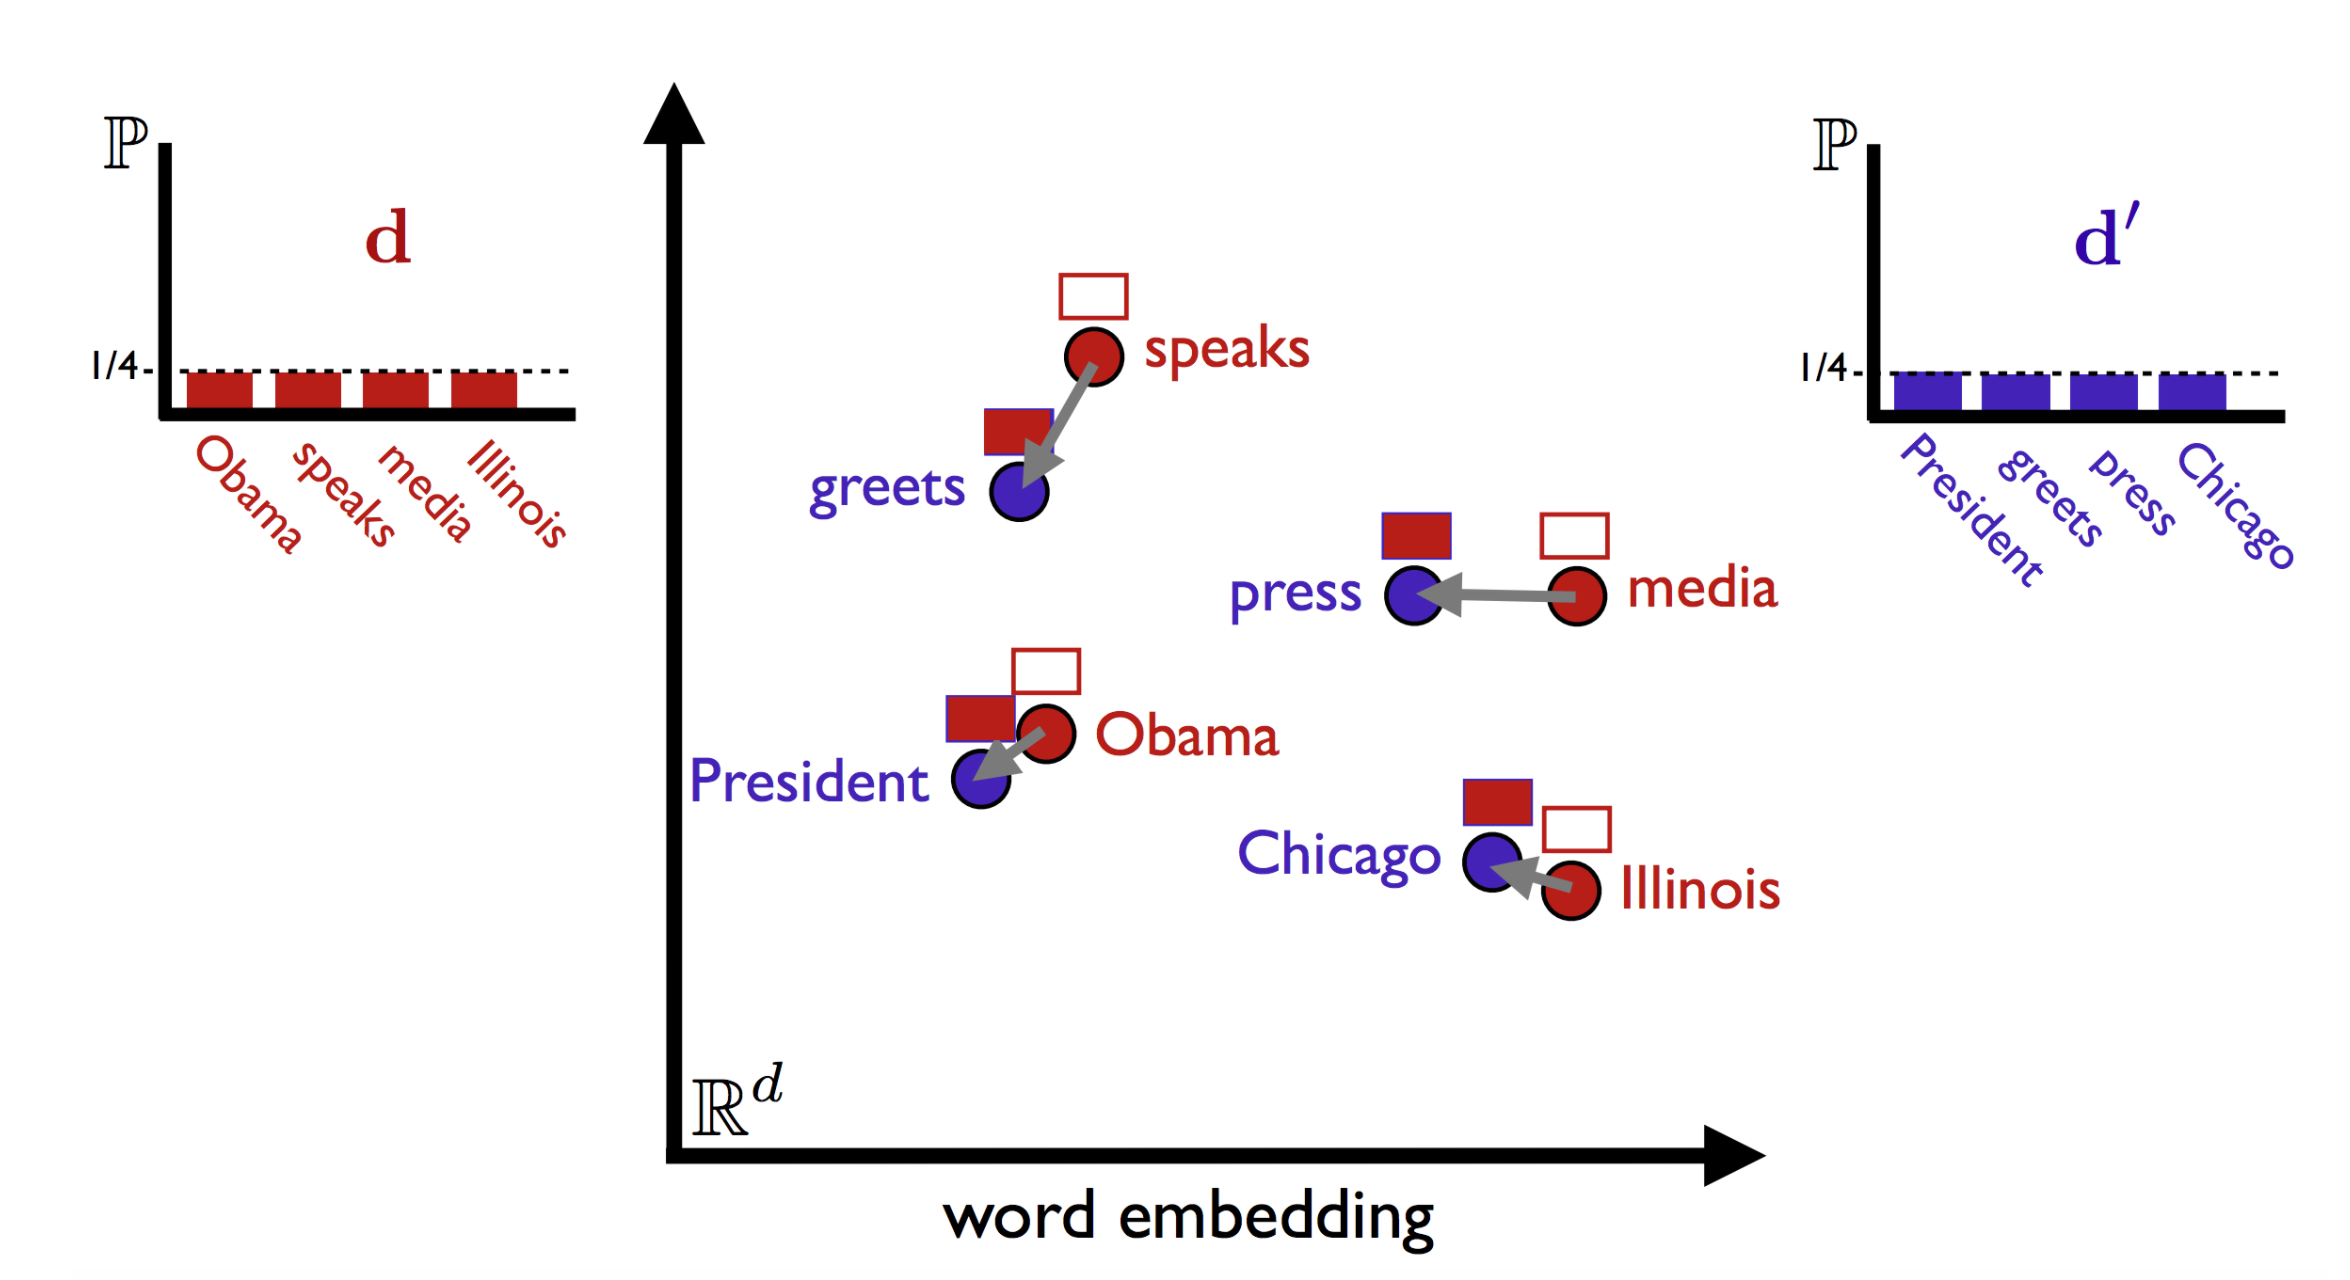

如上图所示，d 和 d' 为需要计算相似度的两个文本（已去除了停用词），坐标系上的每个点对应一个单词，是其在词向量空间上的表示，两个文本的单词分别用不同的颜色来表示，词汇间的距离可用词向量间的距离（比如余弦相似度）来衡量。现在，我们想知道两个文本间的距离，一个直观的方案是，对于某一文本中的某一单词，计算与其最近的另一文本中的单词的距离是多少，将这些距离相加，便可认为是从一个文本“移动”到另一个文本所需的代价，也就是说，这些距离越大，两者便越不相似，反之亦如此。

但是上述方案存在两个基本漏洞，首先，一些重要的单词（比如 “Obama” 可能是个更重要的单词）“移动”的代价应该对最终的距离产生更大的影响；另一方面，某一文本中的某一单词，与另一文本中的所有单词均可能存在关系。因此基于这两点，可以基于词频给每个单词分配权重，突出不同单词的重要性；每个单词都可以“移动”至另一文本中的所有单词，即计算两两单词间的距离，但实际上这些“移动”距离本身的重要性也并不一致（例如 “speaks” 和 “greets”之间的距离比其与其它单词的距离更重要），不能单纯地相加，因此也要对距离分配权重，如下图（以单词 “speaks” 为例）所示：

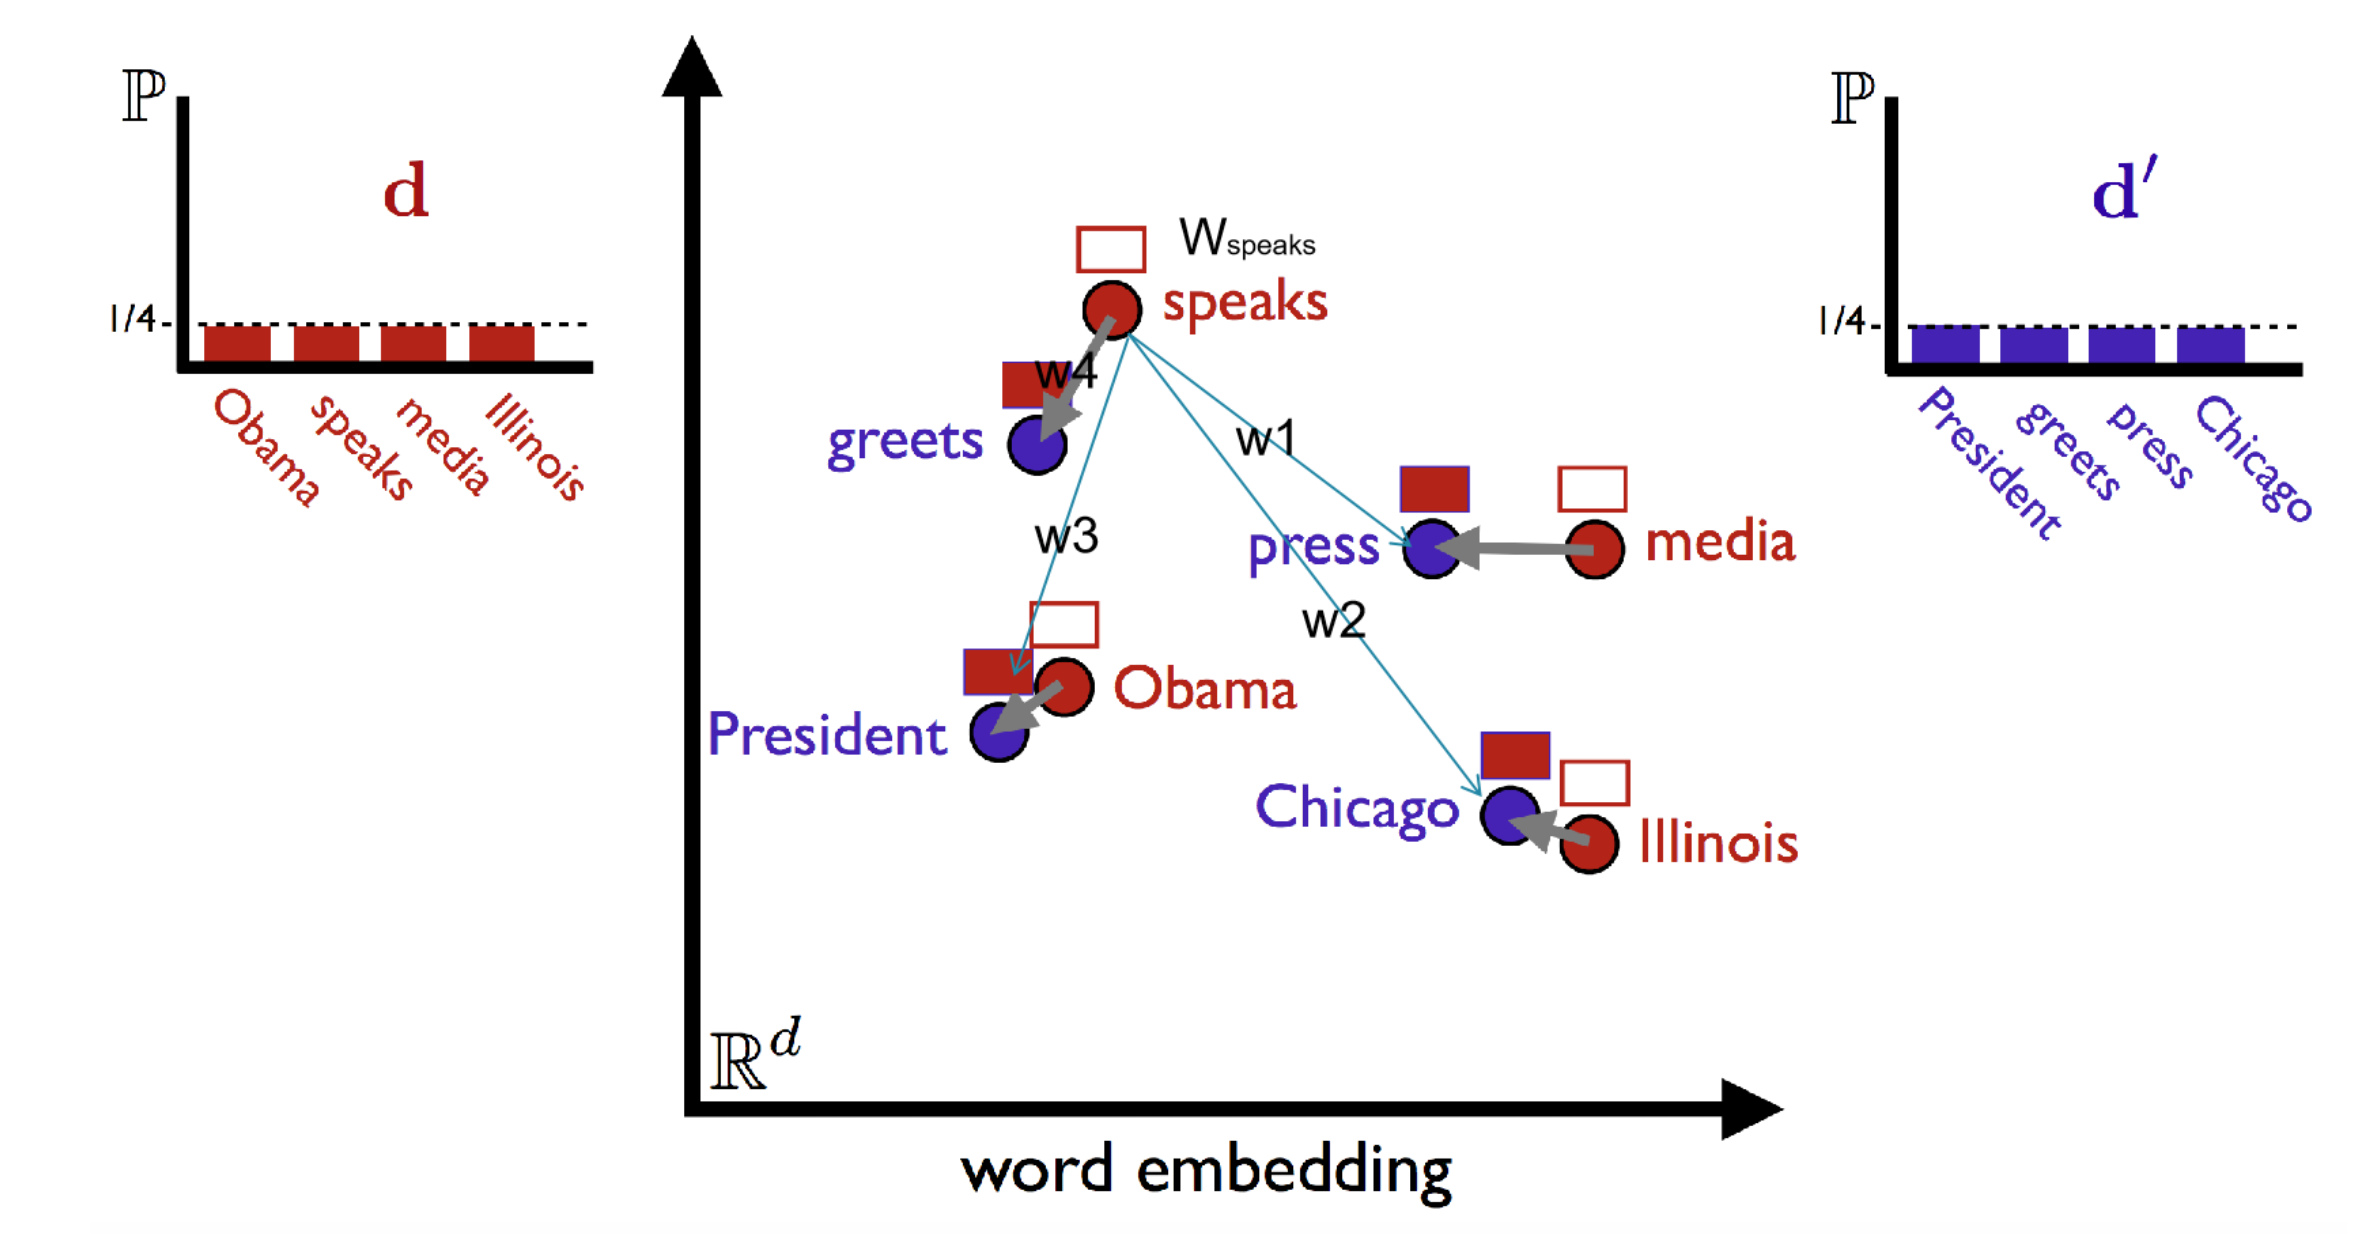

已知单词的权重可通过词频计算而得，那么如何分配距离的权重呢？在 WMD 算法中，距离的权重分配需要满足两个条件：

- 每个单词“移动”代价的权重之和等于此单词的权重，即 $ W_{speaks} = w_1 + w_2 + w_3 + w_4$ （以上图中的符号为准）。
- 被作为“移动”目标的每个单词所接收的“移动”代价的权重之和为此单词的权重，即 $ W_{greets} = w_1 + w_2 + w_3 + w_4$ （以下图中的符号为准）。

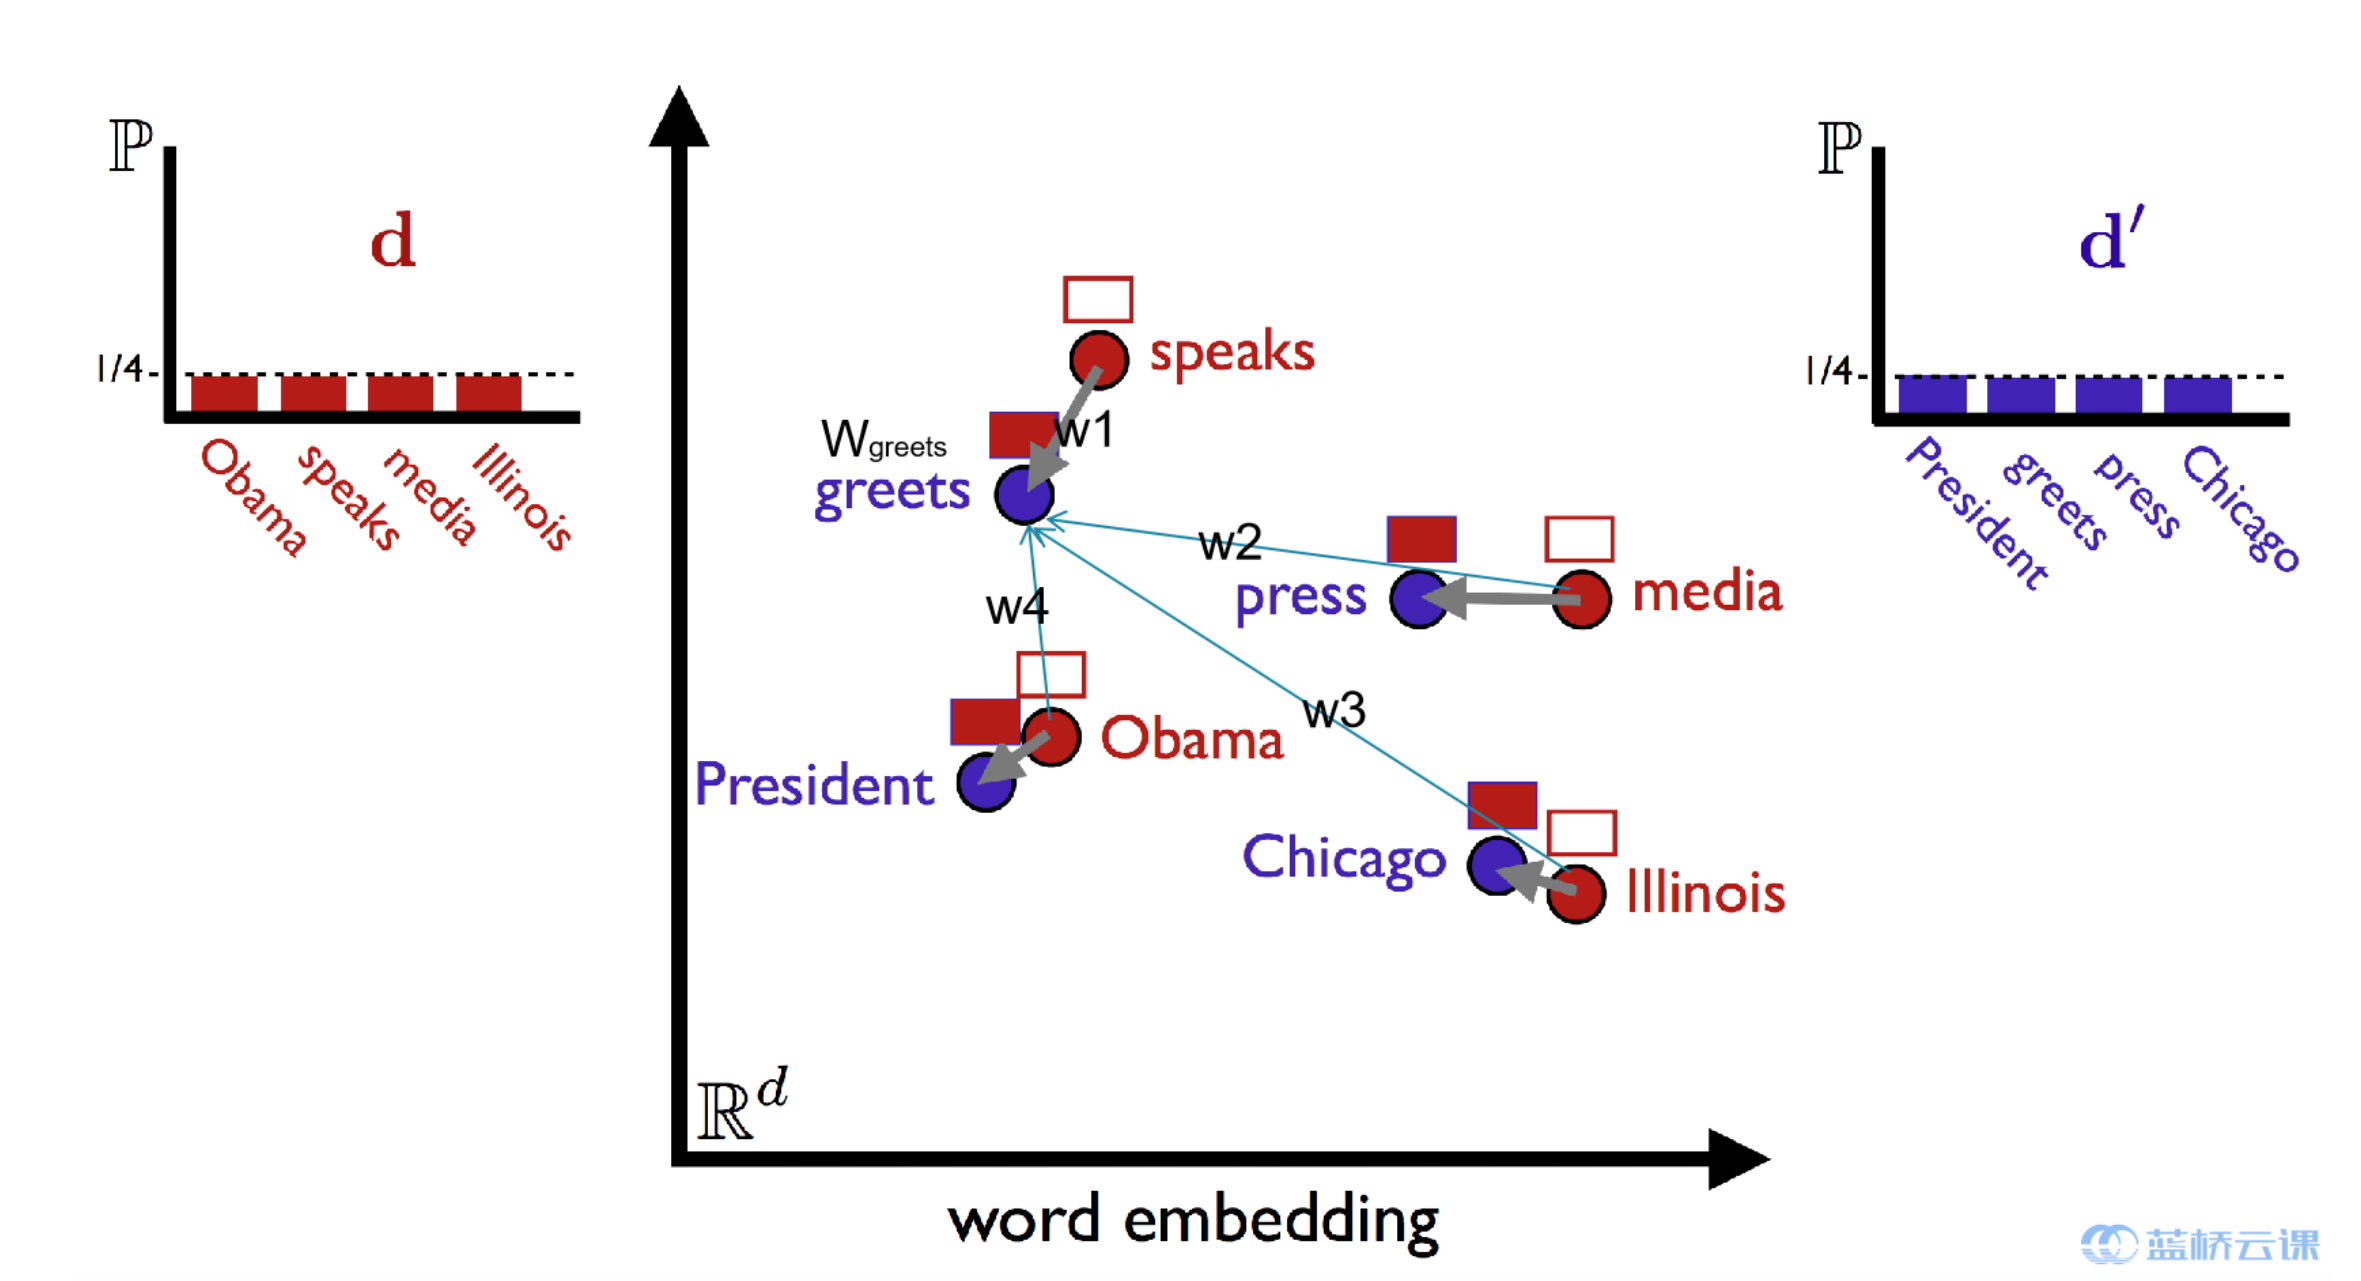

在满足以上条件的基础上计算最小的“移动”代价，实质上为线性规划问题，这里不再详述，可参考 EMD 的解法。而在实际应用中，可调用 Gensim 中的相关函数快速实现基于 WMD 的文本距离运算。

In [ ]:
# 基于 WMD 的文本距离运算
def compute_wmd_distance(text1, text2, w2v_model):
    w2v_model.init_sims(replace=True)  # 对词向量进行归一化
    return w2v_model.wmdistance(jieba.lcut(text1), jieba.lcut(text2))

In [ ]:
!pip install pyemd
# 载入词向量模型
hongloumeng_w2v_model = KeyedVectors.load_word2vec_format(
    "hongloumeng_model.bin", binary=True)
text1 = "黛玉在林中赏月"
text2 = "宝玉在林间闲逛"
text3 = "宝钗喜欢去二爷家串门"
# 注意，距离值越大，表示越不相似
print(compute_wmd_distance(text1, text2, hongloumeng_w2v_model),
      compute_wmd_distance(text2, text3, hongloumeng_w2v_model))

最后要讲的基于编辑距离的文本相似度计算事实上是应用地最早的相似度计算方法，特别是针对以字母为基础的语言而言。

编辑距离算法，又叫 Levenshtein Distance 算法，是指两个字符串之间，由一个转成另一个所需的最少编辑操作次数。许可的编辑操作包括将一个字符替换成另一个字符，插入一个字符，删除一个字符。一般来说，编辑距离越小，两个串的相似度越大。此部分在实验四中已涉及，不再赘述，这里主要介绍如何调用工具  FuzzyWuzzy 进行文本间的相似度计算。

FuzzyWuzzy 是一个简单易用的模糊字符串匹配工具包。它依据 Levenshtein Distance 算法计算两个序列之间的差异，并且提供了多种计算模式。

简单匹配模式：

In [ ]:
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz

# 输出值转换到了  0-100 之间，值越大，两文本相似度越高
fuzz.ratio("this is a test", "this is a test!")

非完全匹配模式：

In [ ]:
# 前一文本包含在后一文本中，两者相似分为 100，可用于一些搜索的场景
fuzz.partial_ratio("this is a test", "this is a test!")

忽略顺序的匹配模式：

In [ ]:
fuzz.token_sort_ratio("fuzzy wuzzy was a bear", "wuzzy fuzzy was a bear")

去重子集匹配模式：

In [ ]:
# 后一文本中的 fuzzy 会被去重
fuzz.token_set_ratio("fuzzy was a bear", "fuzzy fuzzy was a bear")

基于编辑距离的文本相似度计算虽然简单，但相比于前两种方法却有一定的优势：编辑距离会考虑词序，而在前两种方案中，虽然语义表征能力更强，但并不关注文本中词序，如果两文本中出现的单词一致，但顺序不同，最终的相似度为 100%，但并不总是合理（比如“爸爸打我”，“我打爸爸”）。在实践中，可以多种方式组合，优势互补，进行相似度的评判。

### 实验总结

如何有效地用数值化的形式将符号形式的语言表达出来，一直是自然语言处理历史上的重难点。本实验主要学习了文本表征的几种方法，以及进一步地，如何计算文本之间的相似度，主要包括以下知识点：

- 基于频次的文本表征
- 基于 TF-IDF 的文本表征
- 基于词向量的文本表征
- 如何计算文本相似度

在下一实验中，我们将学习自然语言处理中非常普遍的一个任务，文本分析，具体而言，我们将把“对外卖订单中的评论分析”作为具体的实战案例。